In [17]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, confusion_matrix, 
                            classification_report, roc_auc_score,
                            precision_recall_curve, average_precision_score)
from imblearn.combine import SMOTETomek
from xgboost import XGBClassifier
import joblib
from collections import Counter

In [2]:
# Load data
df = pd.read_csv('excel_bioactivity_data_with_descriptors2.csv')

# 1. Verify and map class labels (critical step)
print("Original class distribution:")
print(df['bioactivity_class'].value_counts(dropna=False))

Original class distribution:
bioactivity_class
inactive    1624
active       744
Name: count, dtype: int64


In [3]:
# Drop rows with NaN in target variable
df = df.dropna(subset=['bioactivity_class'])

# Verify case sensitivity in class labels
print("\nUnique class values:", df['bioactivity_class'].unique())

# Convert to lowercase and strip whitespace to standardize
df['bioactivity_class'] = df['bioactivity_class'].str.lower().str.strip()



Unique class values: ['active' 'inactive']


In [4]:
# Map classes (ensure correct majority/minority)
class_mapping = {'active': 0, 'inactive': 1}
df['bioactivity_class'] = df['bioactivity_class'].map(class_mapping)

# Check for successful mapping
print("\nAfter mapping:")
print(df['bioactivity_class'].value_counts())

# Prepare features and target
X = df[['MolWt', 'NumRotatableBonds', 'NumHAcceptors', 'NumHDonors', 'TPSA', 'MolLogP']]
y = df['bioactivity_class'].values


After mapping:
bioactivity_class
1    1624
0     744
Name: count, dtype: int64


In [5]:
try:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=0.2, 
        random_state=42, 
        stratify=y
    )
    print("\nSplit successful!")
    print("Train class distribution:", np.unique(y_train, return_counts=True))
    print("Test class distribution:", np.unique(y_test, return_counts=True))
except ValueError as e:
    print("\nError during split:", e)
    print("Possible causes:")
    print("- NaN values still present in y:", np.isnan(y).any())
    print("- Insufficient samples for stratification")


Split successful!
Train class distribution: (array([0, 1]), array([ 595, 1299]))
Test class distribution: (array([0, 1]), array([149, 325]))


C:\Users\akhil\AppData\Local\Temp\ipykernel_11364\1408355081.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Active', 'Inactive'],


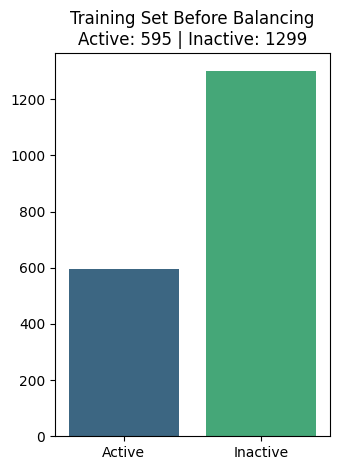

In [6]:
plt.subplot(1, 2, 2)
train_counts = Counter(y_train)
sns.barplot(x=['Active', 'Inactive'], 
            y=[train_counts[0], train_counts[1]], 
            palette='viridis')
plt.title('Training Set Before Balancing\nActive: {} | Inactive: {}'.format(
    train_counts[0], train_counts[1]))
plt.tight_layout()
plt.show()

In [7]:
# 3. Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [8]:

# 4. Balance training data only (SMOTE-Tomek)
print("\nBefore resampling:", dict(zip(['Active', 'Inactive'], np.unique(y_train, return_counts=True)[1])))
smt = SMOTETomek(random_state=42)
X_train_bal, y_train_bal = smt.fit_resample(X_train_scaled, y_train)
print("After resampling:", dict(zip(['Active', 'Inactive'], np.unique(y_train_bal, return_counts=True)[1])))


Before resampling: {'Active': np.int64(595), 'Inactive': np.int64(1299)}
After resampling: {'Active': np.int64(1221), 'Inactive': np.int64(1221)}


C:\Users\akhil\AppData\Local\Temp\ipykernel_11364\1276073114.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Active', 'Inactive'],


Text(0.5, 1.0, 'Training Set After SMOTE-Tomek\nActive: 1221 | Inactive: 1221')

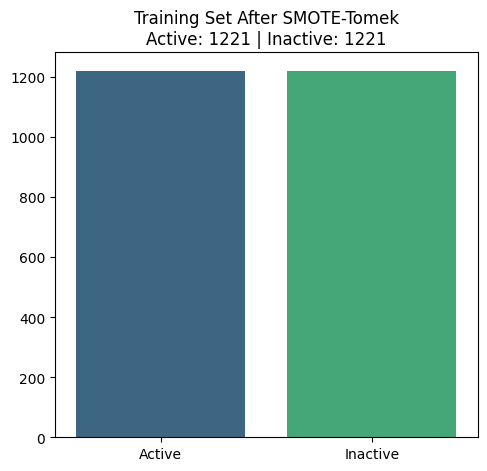

In [9]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
bal_counts = Counter(y_train_bal)
sns.barplot(x=['Active', 'Inactive'], 
            y=[bal_counts[0], bal_counts[1]], 
            palette='viridis')
plt.title('Training Set After SMOTE-Tomek\nActive: {} | Inactive: {}'.format(
    bal_counts[0], bal_counts[1]))

C:\Users\akhil\AppData\Local\Temp\ipykernel_11364\987280725.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Active', 'Inactive'],


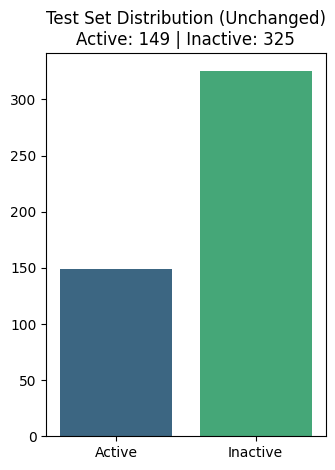

In [10]:
plt.subplot(1, 2, 2)
test_counts = Counter(y_test)
sns.barplot(x=['Active', 'Inactive'], 
            y=[test_counts[0], test_counts[1]], 
            palette='viridis')
plt.title('Test Set Distribution (Unchanged)\nActive: {} | Inactive: {}'.format(
    test_counts[0], test_counts[1]))
plt.tight_layout()
plt.show()

In [11]:
# 5. Train XGBoost with proper class weighting
# Calculate weight ratio: majority_class / minority_class
scale_pos_weight = sum(y_train == 0) / sum(y_train == 1)  # Active=0 (minority), Inactive=1 (majority)

model = XGBClassifier(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,  # Penalize misclassifying Active (minority)
    random_state=42,
    eval_metric='aucpr'
)


In [12]:
model.fit(X_train_bal, y_train_bal)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, ...)

In [13]:
# 6. Evaluate
y_pred = model.predict(X_test_scaled)
y_proba = model.predict_proba(X_test_scaled)[:, 1]  # Probability of class 1 (Inactive)

print("\nEvaluation Metrics:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.2f}")
print(f"Average Precision: {average_precision_score(y_test, y_proba):.2f}")


Evaluation Metrics:
Accuracy: 0.67
ROC AUC: 0.74
Average Precision: 0.86



Classification Report:
              precision    recall  f1-score   support

      Active       0.48      0.70      0.57       149
    Inactive       0.83      0.66      0.73       325

    accuracy                           0.67       474
   macro avg       0.66      0.68      0.65       474
weighted avg       0.72      0.67      0.68       474



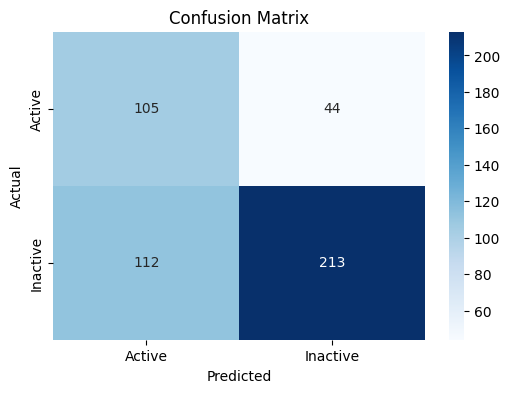

In [14]:
# Classification report (use original class names)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Active', 'Inactive']))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Active', 'Inactive'], 
            yticklabels=['Active', 'Inactive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

C:\Users\akhil\AppData\Local\Temp\ipykernel_11364\601388845.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_imp, palette='viridis')


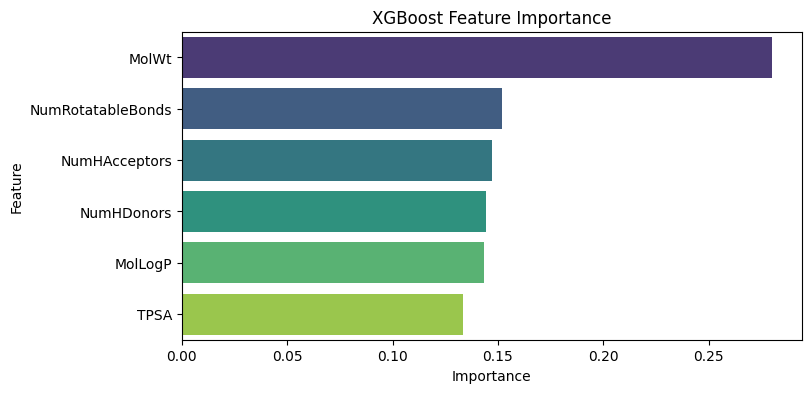

In [15]:
# Feature importance
feature_imp = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(8, 4))
sns.barplot(x='Importance', y='Feature', data=feature_imp, palette='viridis')
plt.title('XGBoost Feature Importance')
plt.show()

In [20]:
# Save artifacts
save_path = r"C:\Users\akhil\OneDrive\Documents\PYTHON\bioactivity_prediction2"
os.makedirs(save_path, exist_ok=True)

joblib.dump(model, os.path.join(save_path, "xgb_model2.pkl"))
joblib.dump(scaler, os.path.join(save_path, "scaler2.pkl"))

print(f"\nArtifacts saved to: {save_path}")


Artifacts saved to: C:\Users\akhil\OneDrive\Documents\PYTHON\bioactivity_prediction2
